In [402]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from iminuit import Minuit


fixed_enum = [1, 2, 3]  # no of balls and tries
fixed_keys = ['11', '12', '13', '21', '22', '23', '31', '32', '33'] # the key 'ij' (string) will correspond to the i-th ball and j-th try

def data_extractor(flipped=False):
    '''Extracts data from folder 'ball_data' and converts it into dictionaries
    Returns the 'times' and 'voltages' dictionaries
    When argument 'flipped' is set to True it extracts from files with 'flipped' in their names'''
    raw_data = {}
    for i in fixed_enum:
        for j in fixed_enum:
            if not flipped:
                filename = f'ball{i}_try{j}.csv'
            else:
                filename = f'ball{i}_try{j}_flipped.csv'
            with open(f'data/{filename}', 'r') as file:
                raw_data[f'{i}{j}'] = file.readlines()[15:]    
                

    times = {}
    voltages = {}

    for key, value in raw_data.items():
        times[key] = np.array([float(line.split(',')[0].strip()) for line in value])
        voltages[key] = np.array([float(line.split(',')[1].strip()) for line in value])
    return times, voltages

times, voltages = data_extractor()
times_f, voltages_f = data_extractor(True)



In [403]:
def left_edges_extractor(times, voltages):
    '''
    Extracts the left edges of the peaks in voltages. Returns dictionaries with edge times and corresponding voltages
    '''
    edge_times = {}
    edge_volts = {}
    # Loop over keys: {'11', '12', ..., '33'}
    for key in fixed_keys:
        times_buff = []
        volts_buff = []
        v_prev = 0
        for t, volt in zip(times[key], voltages[key]):
            # if np.abs(volt - 4.78) < 0.1 and np.abs(volt - v_prev) > 0.1:
            if volt > 2.5 and v_prev < 2.5:
                times_buff.append(t)
                volts_buff.append(volt)
            v_prev = volt
        # making sure that some extra edge didn't leak
        if len(times_buff) != 5:
            to_delete = []
            for i in range(len(times_buff) - 1):
                if (times_buff[i + 1] - times_buff[i]) < 0.05:
                    to_delete.append(i + 1)
            for ind in to_delete:
                del times_buff[ind]
                del volts_buff[ind]
        edge_times[key] = np.array(times_buff)
        edge_volts[key] = np.array(volts_buff)

    return edge_times, edge_volts



def right_edges_extractor(times, voltages):
    edge_times = {}
    edge_volts = {}
    for key in fixed_keys:
        times_buff = []
        volts_buff = []
        v_prev = 0
        for t, volt in zip(times[key], voltages[key]):
            if v_prev > 2.5 and volt < 2.5:
                times_buff.append(t)
                volts_buff.append(volt)
            v_prev = volt
        if len(times_buff) != 5:
            to_delete = []
            for i in range(len(times_buff) - 1):
                if (times_buff[i + 1] - times_buff[i]) < 0.05:
                    to_delete.append(i)
            for ind in to_delete:
                del times_buff[ind]
                del volts_buff[ind]
        edge_times[key] = np.array(times_buff)
        edge_volts[key] = np.array(volts_buff)
    return edge_times, edge_volts




def midpoints_extractor(times, voltages):
    l_edges, _ = left_edges_extractor(times, voltages)
    r_edges, _ = right_edges_extractor(times, voltages)
    mid_times = {}
    errors = {}
    for key in fixed_keys:
        mid_times[key] = (r_edges[key] + l_edges[key])/2
        errors[key] = 0.68*(r_edges[key] - l_edges[key])
    return mid_times, errors

    
    


midpoints, mid_errs = midpoints_extractor(times, voltages)
midpoints_f, mid_errs_f = midpoints_extractor(times_f, voltages_f)




def shift_to_zero(times, entry_times):
    times_shifted = {}
    edge_times_shifted = {}
    for key in fixed_keys:
        first_value = entry_times[key][0]
        time_copy = np.copy(times[key])
        time_copy -= first_value*np.ones_like(time_copy)
        edge_time_copy = np.copy(entry_times[key])
        edge_time_copy -= first_value*np.ones_like(edge_time_copy) 

        times_shifted[key] = time_copy
        edge_times_shifted[key] = edge_time_copy
    return times_shifted, edge_times_shifted
print(midpoints['11'])

times, midpoints = shift_to_zero(times, midpoints)
times_f, midpoints_f = shift_to_zero(times_f, midpoints_f)
print(type(midpoints['11']))


[0.7881 1.0322 1.2041 1.3375 1.461 ]
<class 'numpy.ndarray'>


In [404]:
def volts_vs_time_plot(ball_no, times, voltages, edge_times, name, interval=(-0.05, 0.7)):
    a, b = interval

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(name)

    axs[0].plot(times[f'{ball_no}1'], voltages[f'{ball_no}1'])
    axs[0].set_title(f"Ball {ball_no}, try 1")
    axs[0].set_xlabel('time (s)')
    axs[0].set_ylabel('voltage (V)')

    for t in edge_times[f'{ball_no}1']:
        axs[0].axvline(x=t, color='red', linestyle='--')
    axs[0].set_xticks(ticks=edge_times[f'{ball_no}1'])

    axs[1].plot(times[f'{ball_no}2'], voltages[f'{ball_no}2'])
    axs[1].set_title(f"Ball {ball_no}, try 2")
    axs[1].set_xlabel('time (s)')
    axs[1].set_ylabel('voltage (V)')

    for t in edge_times[f'{ball_no}2']:
        axs[1].axvline(x=t, color='red', linestyle='--')
    axs[1].set_xticks(ticks=edge_times[f'{ball_no}2'])

    axs[2].plot(times[f'{ball_no}3'], voltages[f'{ball_no}3'])
    axs[2].set_title(f'Ball {ball_no}, try 3')
    axs[2].set_xlabel('time (s)')
    axs[2].set_ylabel('voltage (V)')
    for t in edge_times[f'{ball_no}3']:
        axs[2].axvline(x=t, color='red', linestyle='--')
    axs[2].set_xticks(ticks=edge_times[f'{ball_no}3'])
    # Limits for x
    axs[0].set_xlim(a, b)
    axs[1].set_xlim(a, b)
    axs[2].set_xlim(a, b)

    for ax in axs:
        ax.grid(True)

    plt.tight_layout()
    plt.show()


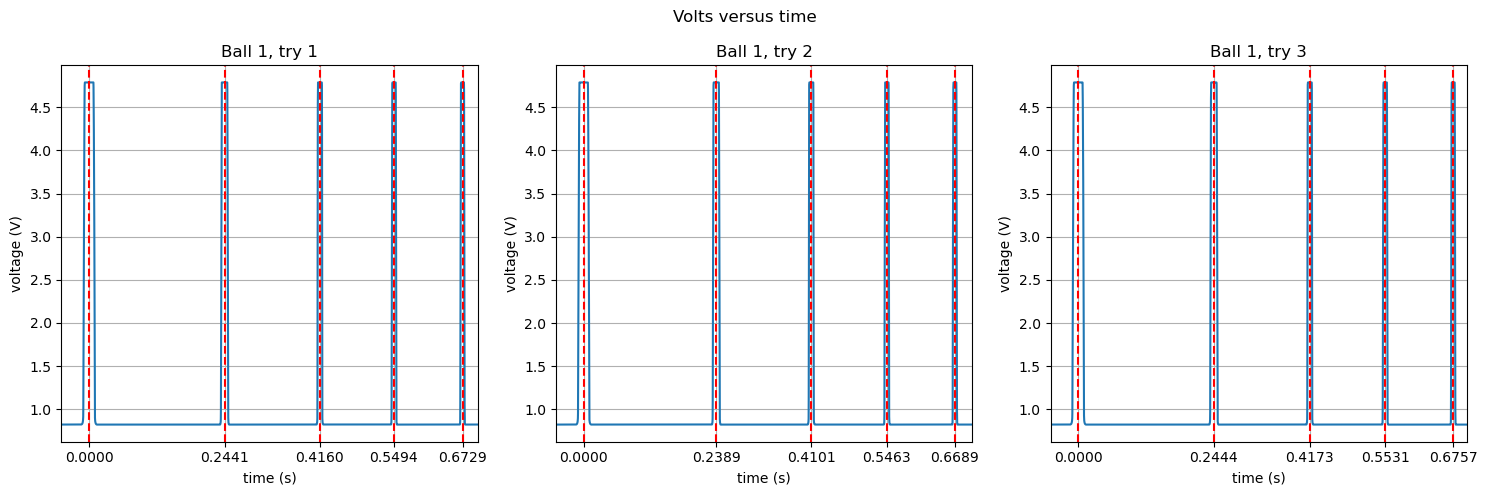

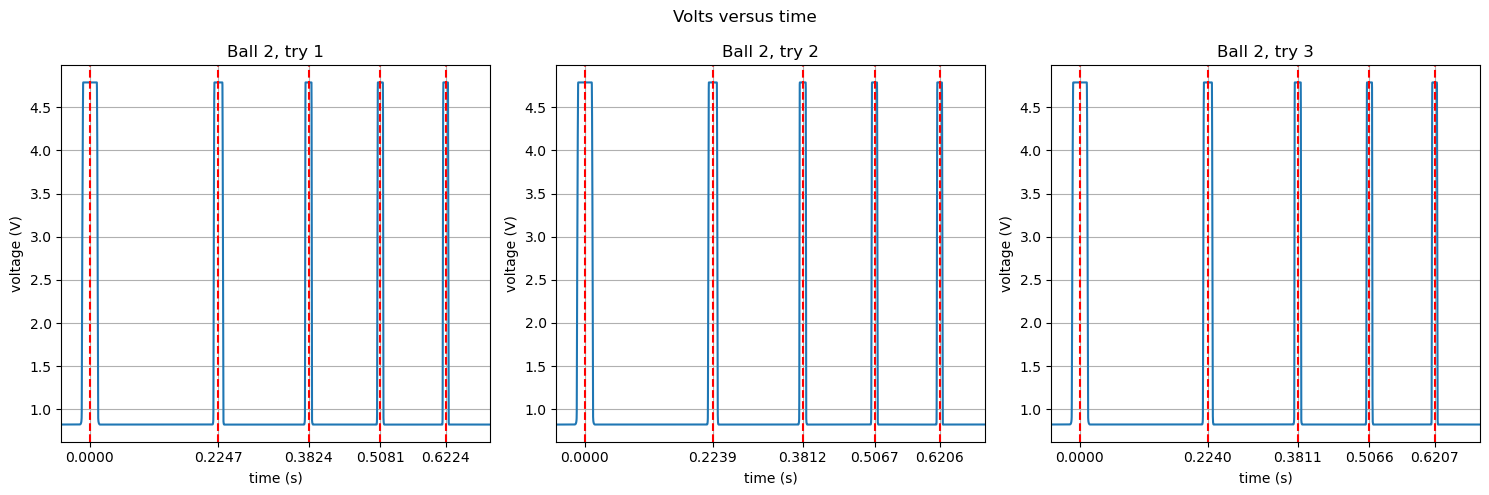

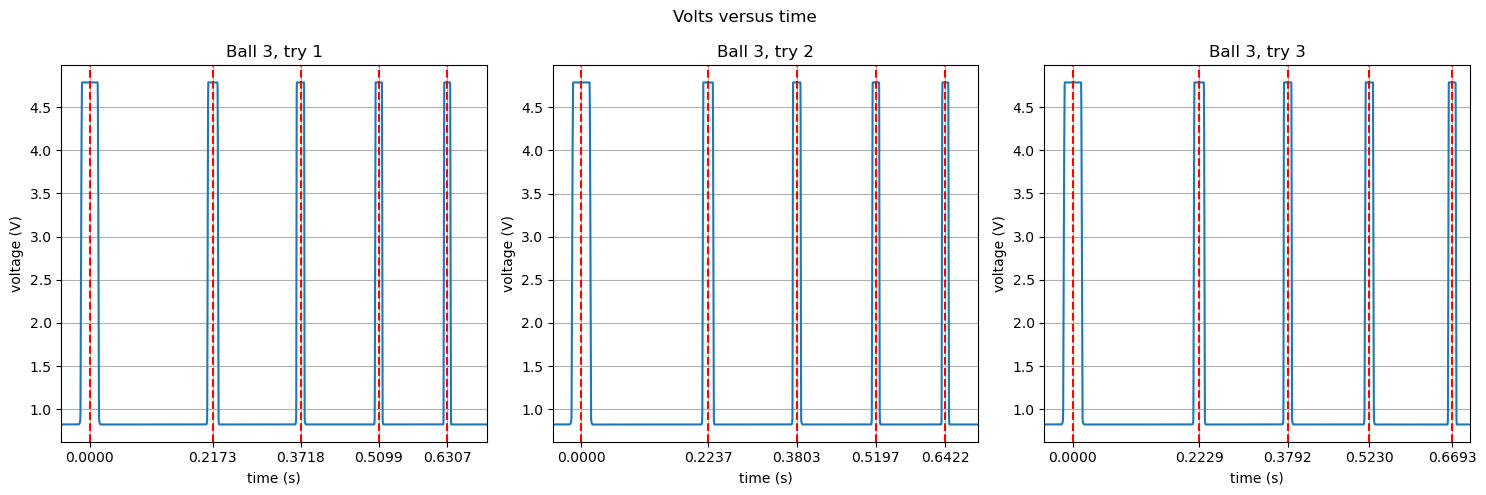

In [405]:

for ball in fixed_enum:
    volts_vs_time_plot(ball, times, voltages, midpoints, 'Volts versus time')



### Gate positions data treatment
Need to be done only once :)

In [406]:

def constant_fit(data, error):
    '''Performs fit of a constant function using chi2 method'''
    value = sum(data/error**2)*1/sum(1/error**2)
    val_error = np.sqrt(1/sum(1/error**2))
    return value, val_error


# Gate positions measurements
x_miguel = np.array([81.5, 65.33, 50.45, 35.25, 20.3])/100
x_michal = np.array([80.8, 65.15, 50.35, 35.05, 20.15])/100
x_sara = np.array([80.95, 65.15, 50.30, 35.05, 20.15])/100
error_x = 0.05/100

# Inverting the data (first gate reached had the lowest position value)
x_miguel = x_miguel[::-1] - x_miguel[-1]
x_michal = x_michal[::-1] - x_michal[-1]
x_sara = x_sara[::-1] - x_sara[-1]

# making a 3x5 array out of the data
x_blocked = np.block([[x_miguel], [x_michal], [x_sara]])
print(x_blocked)

x_mean = []
x_errors = []

# calculating the mean (using chi2 constant fit although regular mean would work cause all uncertainties are the same)
for col in x_blocked.T:
    val, err = constant_fit(col, error_x*np.ones_like(col))
    x_mean.append(val)
    x_errors.append(err)
# array with mean positions
x_mean = np.array(x_mean)
# array with uncertainties of the mean positions
x_errors = np.array(x_errors)



[[0.     0.1495 0.3015 0.4503 0.612 ]
 [0.     0.149  0.302  0.45   0.6065]
 [0.     0.149  0.3015 0.45   0.608 ]]


### Fiting the data to calculate acceleration

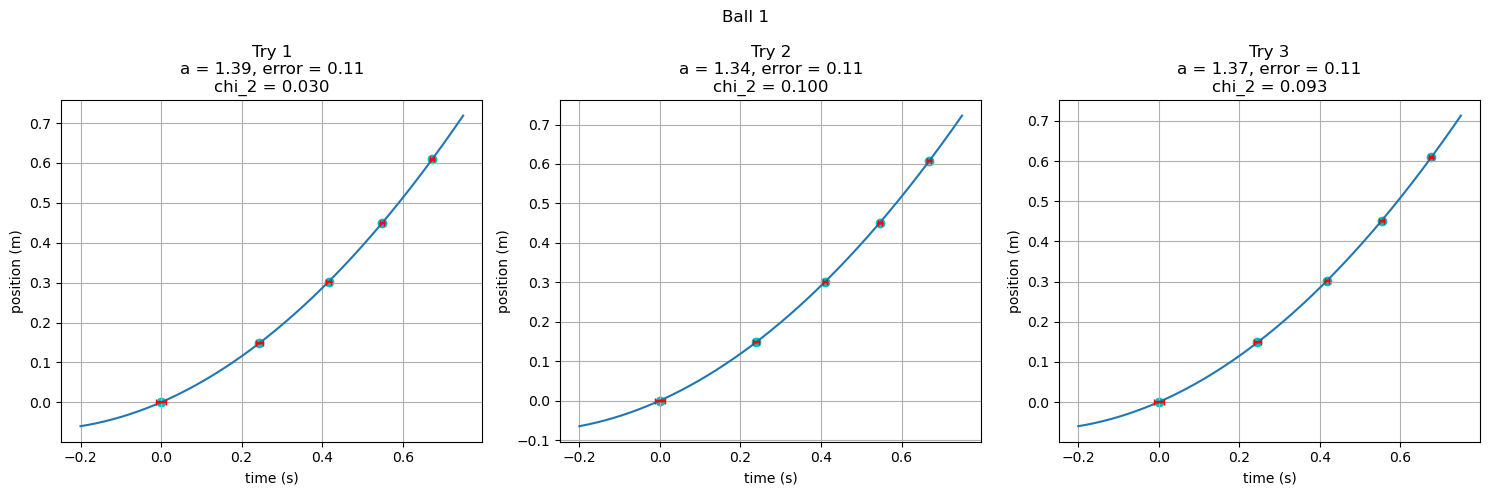

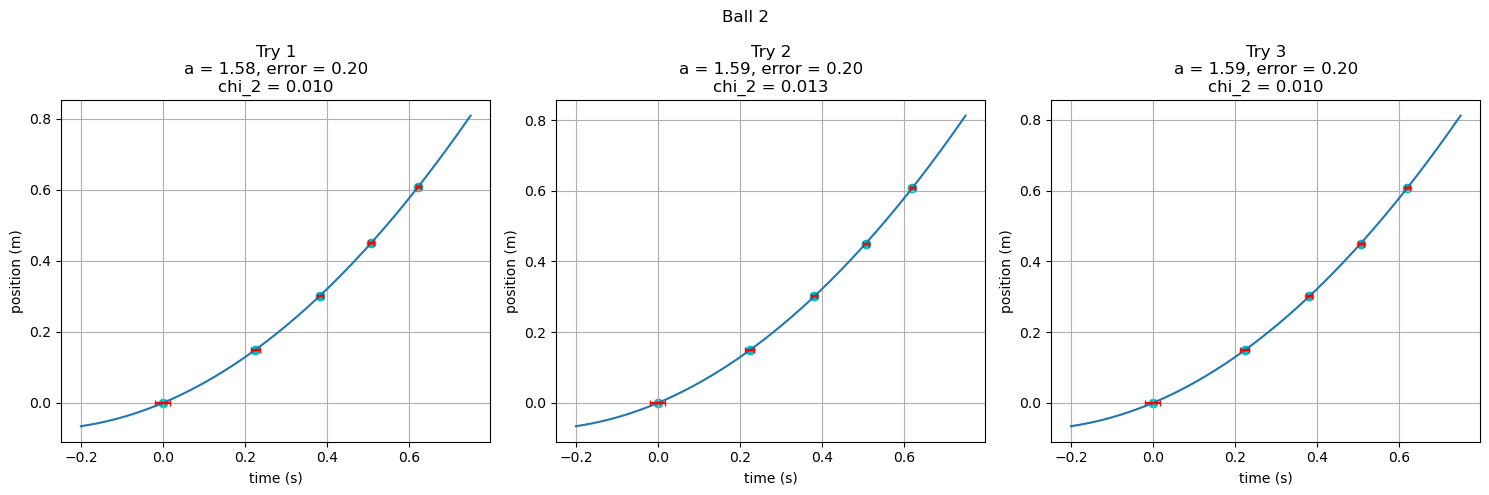

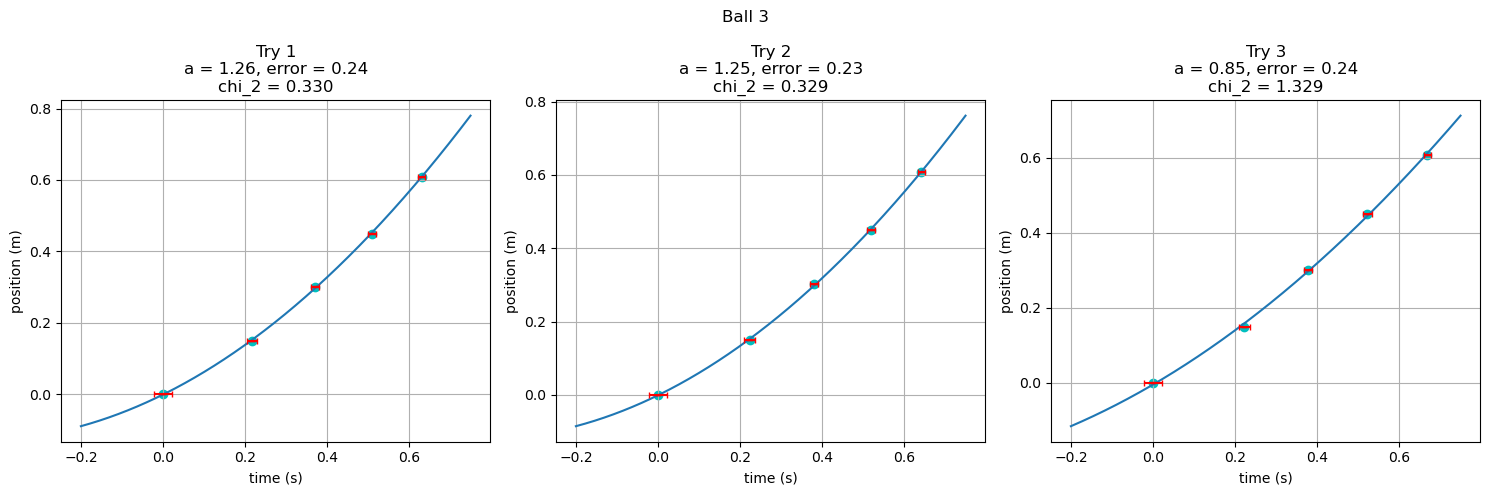

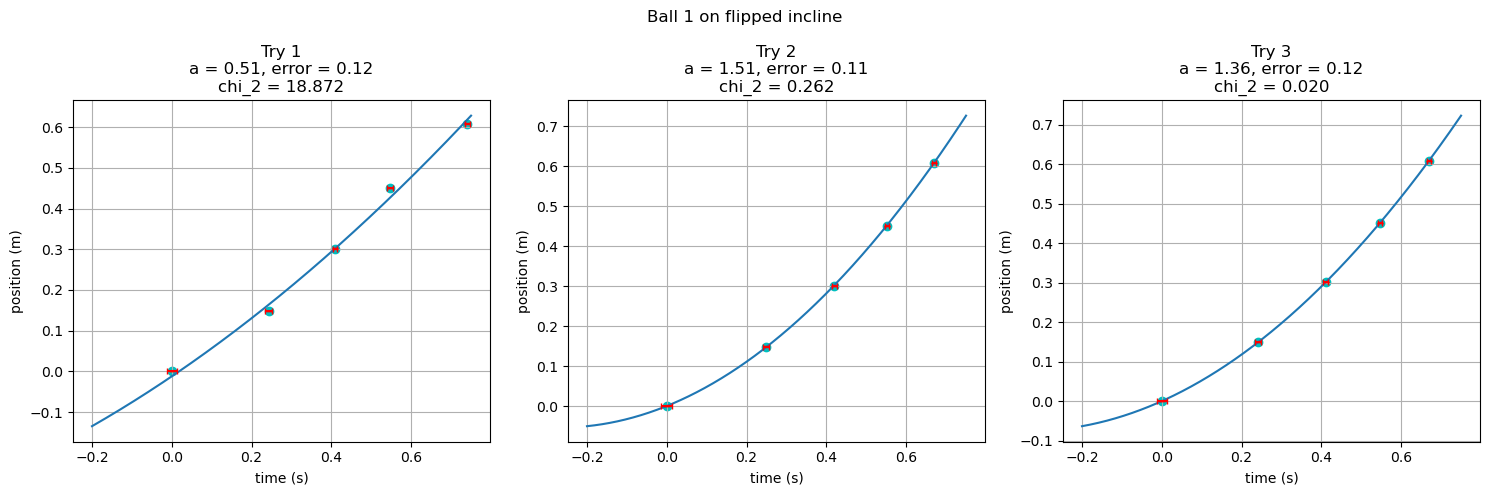

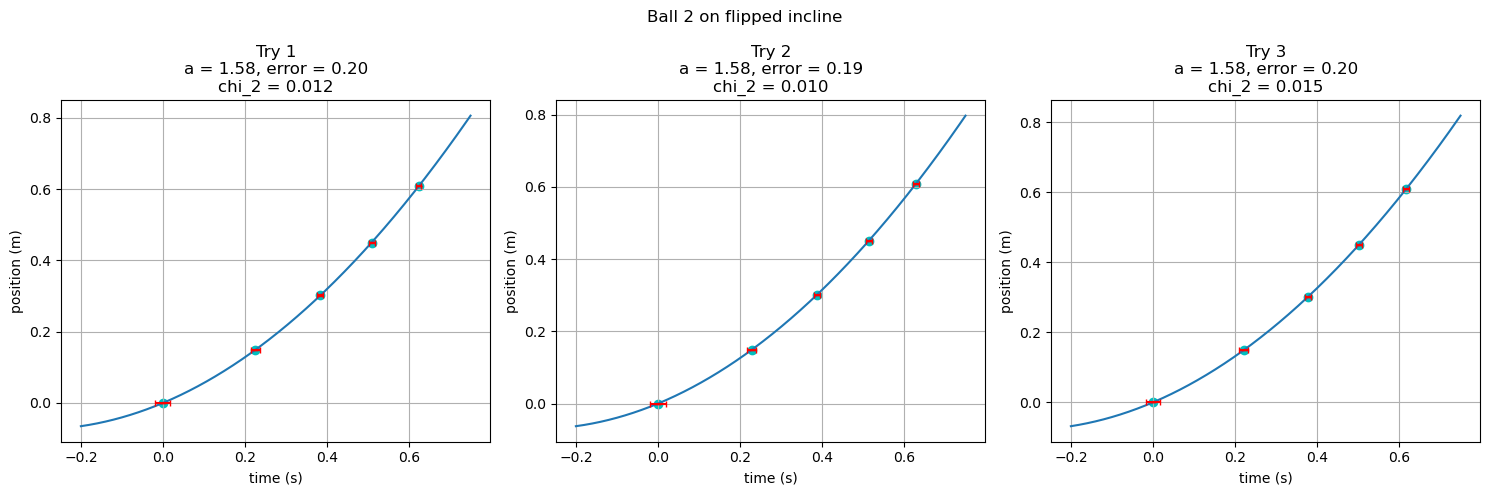

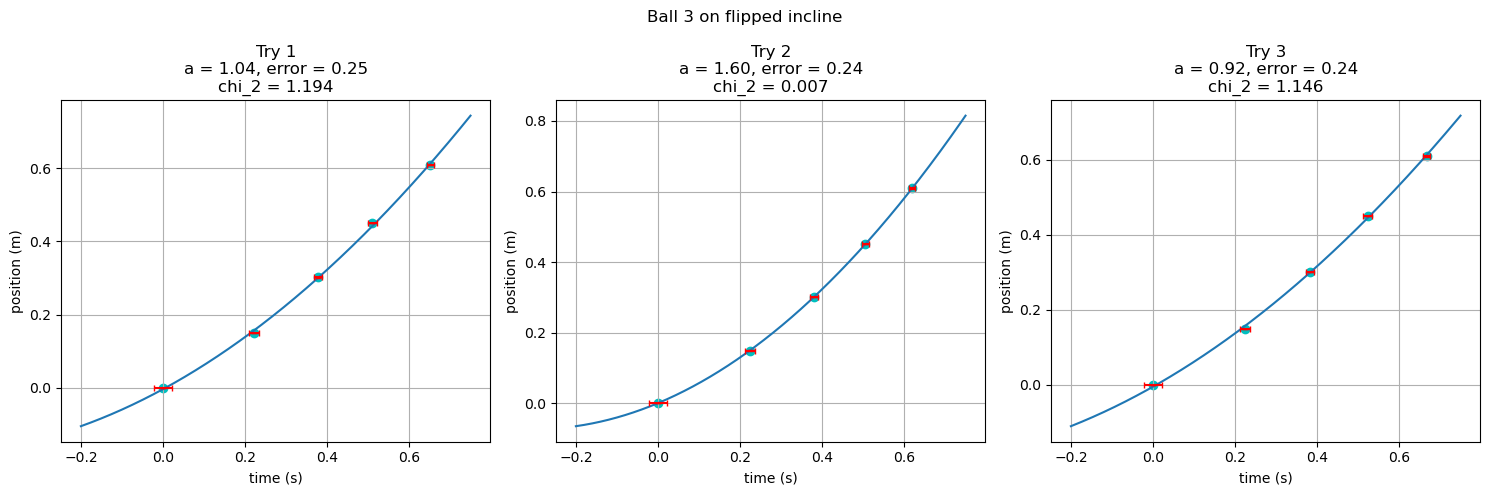

In [407]:
def quadratic_function(t, a, b, c):
    return 0.5*a*t**2+b*t+c

def quadratic_chi2(times, error_t, positions, error_x):
    """
    Returns chi2 to minimize that is only dependent on the fit parameters
    """
    def deriv(a, b):
        '''Derivative of the quadratic function is needed to include time errors'''
        return a*times + b
    
    def chi2_parameters(a, b, c):
        # 2 stands for square:
        error_combined2 = error_x**2 + deriv(a, b)**2*error_t**2
        chi2_val = sum((positions - quadratic_function(times, a, b, c))**2/error_combined2)
        return chi2_val
    return chi2_parameters

def quadratic_fit_minimizator(times, error_t, positions, error_x):
    '''
    Minimizes the quadratic chi2
    '''

    m = Minuit(quadratic_chi2(times, error_t, positions, error_x), a=0.1, b=0, c=0)
    m.errordef = 1
    m.migrad();

    chi_2 = m.fval
    # print(m.values[0:])
    # print(m.errors[0:])
    return m.values[0:], m.errors[0:], chi_2


# Extracting fit parameters

def position_vs_time_with_fit(no_of_ball, entry_times, t_errors, x_mean, x_errors, precision=2, flipped=False):

    pars1, errs1, chi2_1 = quadratic_fit_minimizator(entry_times[f'{no_of_ball}1'], t_errors[f'{no_of_ball}1'], x_mean, x_errors)
    pars2, errs2, chi2_2 = quadratic_fit_minimizator(entry_times[f'{no_of_ball}2'], t_errors[f'{no_of_ball}2'], x_mean, x_errors)
    pars3, errs3, chi2_3 = quadratic_fit_minimizator(entry_times[f'{no_of_ball}3'], t_errors[f'{no_of_ball}3'], x_mean, x_errors)

    domain = np.linspace(-0.2, 0.75, 1000)
    vals1 = quadratic_function(domain, pars1[0], pars1[1], pars1[2])
    vals2 = quadratic_function(domain, pars2[0], pars2[1], pars2[2])
    vals3 = quadratic_function(domain, pars3[0], pars3[1], pars3[2])

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    if flipped:
        fig.suptitle(f'Ball {no_of_ball} on flipped incline')
    else:
        fig.suptitle(f'Ball {no_of_ball}')
    axs[0].plot(domain, vals1)
    axs[0].scatter(entry_times[f'{no_of_ball}1'], x_mean, color='c')
    axs[0].errorbar(entry_times[f'{no_of_ball}1'], x_mean, xerr=t_errors[f'{no_of_ball}1'], yerr=x_errors, fmt='none', ecolor='red', capsize=2)
    axs[0].set_title(f'Try 1\na = {pars1[0]:.{precision}f}, error = {errs1[0]:.{precision}f}\nchi_2 = {chi2_1:.3f}')
    axs[0].set_xlabel('time (s)')
    axs[0].set_ylabel('position (m)')

    axs[1].plot(domain, vals2)
    axs[1].scatter(entry_times[f'{no_of_ball}2'], x_mean, color='c')
    axs[1].errorbar(entry_times[f'{no_of_ball}2'], x_mean, xerr=t_errors[f'{no_of_ball}2'], yerr=x_errors, fmt='none', ecolor='red', capsize=2)
    axs[1].set_title(f'Try 2\na = {pars2[0]:.{precision}f}, error = {errs2[0]:.{precision}f}\nchi_2 = {chi2_2:.3f}')
    axs[1].set_xlabel('time (s)')
    axs[1].set_ylabel('position (m)')


    axs[2].plot(domain, vals3)
    axs[2].scatter(entry_times[f'{no_of_ball}3'], x_mean, color='c')
    axs[2].errorbar(entry_times[f'{no_of_ball}3'], x_mean, xerr=t_errors[f'{no_of_ball}3'], yerr=x_errors, fmt='none', ecolor='red', capsize=2)
    axs[2].set_title(f'Try 3\na = {pars3[0]:.{precision}f}, error = {errs3[0]:.{precision}f}\nchi_2 = {chi2_3:.3f}')
    axs[2].set_xlabel('time (s)')
    axs[2].set_ylabel('position (m)')

    for ax in axs:
        ax.grid(True)
    plt.tight_layout()
    plt.show()



for i in fixed_enum:
    position_vs_time_with_fit(i, midpoints, mid_errs, x_mean, x_errors)

for i in fixed_enum:
    position_vs_time_with_fit(i, midpoints_f, mid_errs_f, x_mean, x_errors, flipped=True)



In [408]:
def acceleration_computoinator(no_of_ball, entry_times, t_errors_dic, x_mean, x_errors):
    
    pars1, errs1, chi2_a1 = quadratic_fit_minimizator(entry_times[f'{no_of_ball}1'], t_errors_dic[f'{no_of_ball}1'],x_mean, x_errors)
    pars2, errs2, chi2_a2 = quadratic_fit_minimizator(entry_times[f'{no_of_ball}2'], t_errors_dic[f'{no_of_ball}2'],x_mean, x_errors)
    pars3, errs3, chi2_a3 = quadratic_fit_minimizator(entry_times[f'{no_of_ball}3'], t_errors_dic[f'{no_of_ball}3'],x_mean, x_errors)
    
    a = np.array([pars1[0], pars2[0], pars3[0]])
    u_a = np.array([errs1[0], errs2[0], errs3[0]])
    chi2_a = np.array([chi2_a1, chi2_a2, chi2_a3])

    
    return a, u_a, chi2_a


### Angle data treatment


In [409]:
# Angles using trigonometry

def alpha(opposite, adjacent):
    return np.arctan(opposite/adjacent)

def error_alpha(opposite, adjacent, ruler_error=0.1):
    return ruler_error/np.sqrt(opposite**2 + adjacent**2)

op_miguel = 22.2
op_michal = 21.8
op_sara = 22.15

adj_miguel = 89.75
adj_michal = 89.1
adj_sara = 89.75

angle_miguel = alpha(op_miguel, adj_miguel)
u_angle_miguel = error_alpha(op_miguel, adj_miguel)

angle_michal = alpha(op_michal, adj_michal)
u_angle_michal = error_alpha(op_michal, adj_michal)

angle_sara = alpha(op_sara, adj_sara)
u_angle_sara = error_alpha(op_sara, adj_sara)

print(f'Miguel: alpha = {angle_miguel:.5f}, error = {u_angle_miguel:.5f}\nMichal: alpha = {angle_michal:.5f}, error = {u_angle_michal:.5f}\nSara: alpha = {angle_sara:.5f}, error = {u_angle_sara:.5f}')
# Goniometer measurements 

angle_gonio1 = 13.9*np.pi/180 # og orientation
angle_gonio2 = 14.0*np.pi/180  # flipped
u_angle_gonio = 0.05*np.pi/180  # something like that???
# The table deviation from horizontalness
angle_table = 0.1*np.pi/180


print(f'Gonio1: alpha = {angle_gonio1:.5f}, error = {u_angle_gonio:.5f}\nGonio2: alpha = {angle_gonio2:.5f}, error = {u_angle_gonio:.5f}')


Miguel: alpha = 0.24249, error = 0.00108
Michal: alpha = 0.23995, error = 0.00109
Sara: alpha = 0.24196, error = 0.00108
Gonio1: alpha = 0.24260, error = 0.00087
Gonio2: alpha = 0.24435, error = 0.00087


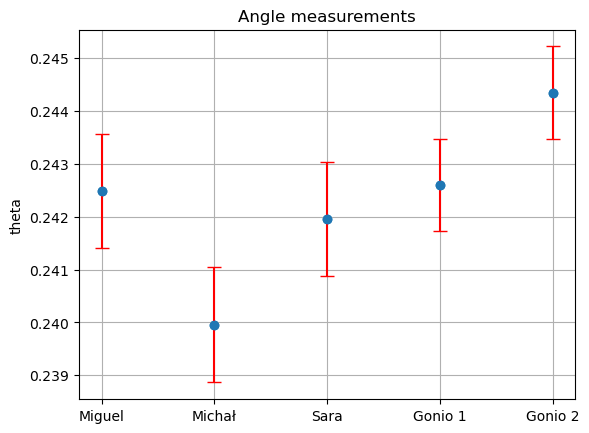

In [410]:

measurements = ['Miguel', 'Michał', 'Sara', 'Gonio 1', 'Gonio 2']
angles_arr = np.array([angle_miguel, angle_michal, angle_sara, angle_gonio1, angle_gonio2])
u_angles_arr = np.array([u_angle_miguel, u_angle_michal, u_angle_sara, u_angle_gonio, u_angle_gonio])

# Create a scatter plot
plt.scatter(measurements, angles_arr)
plt.errorbar(measurements, angles_arr, yerr=u_angles_arr, fmt='o', ecolor='r', capsize=5)
# plt.ylim(bottom=0)
# Add title and labels
plt.title('Angle measurements')
plt.xlabel('')
plt.ylabel('theta')
plt.grid(True)

# Show the plot
plt.show()

### Ball size and rail width data

In [411]:
D1 = 10.0/1000
D2 = 15/1000
D3 = 19/1000
u_D = 0.1/1000

d = 6/1000
u_d = 0.5/1000

# Finally - calculating the g and its error based upon the overall data
## Here I calculate and print the g data using angles obtained by goniometer

In [412]:
def g_fun(a, theta, deltheta, D, d):
    return a/np.sin(theta + deltheta)*(1 + 2/5*D**2/(D**2 - d**2))

def u_g_fun(a, u_a, theta, u_theta, deltheta, u_deltheta, D, u_D, d, u_d):
    '''To check for mistakes - calculating this by hand was a pain in the ass'''
    var = (1 + 2/5*D**2/(D**2 - d**2))**2/np.sin(theta + deltheta)**2*(u_a**2 + (u_theta**2 + u_deltheta**2)*a**2/np.tan(theta + deltheta)**2) + 16/25*a**2/np.sin(theta + deltheta)**2*D**2*d**2/(D**2 - d**2)**4*(d**2*u_D**2 + D**2*u_d**2)
    return np.sqrt(var)

a_dic = {}
u_a_dic = {}
chi_2_dic = {}

a_f_dic = {}
u_a_f_dic = {}
chi_2_f_dic = {}



for i in fixed_enum:
    a, u_a, chi_2 = acceleration_computoinator(i, midpoints, mid_errs, x_mean, x_errors)
    for j in range(len(a)):
        a_dic[f'{i}{j+1}'] = a[j]
        u_a_dic[f'{i}{j+1}'] = u_a[j]
        chi_2_dic[f'{i}{j+1}'] = chi_2[j]

for i in fixed_enum:
    a, u_a, chi_2 = acceleration_computoinator(i, midpoints_f, mid_errs_f,x_mean, x_errors)
    for j in range(len(a)):
        a_f_dic[f'{i}{j+1}'] = a[j]
        u_a_f_dic[f'{i}{j+1}'] = u_a[j]
        chi_2_f_dic[f'{i}{j+1}'] = chi_2[j]


g_dic = {}
u_g_dic = {}

g_f_dic = {}
u_g_f_dic = {}

for key, val in a_dic.items():
    #print(val)
    g_dic[key] = g_fun(val, angle_gonio1, 0, D1, d)
    u_g_dic[key] = u_g_fun(val, u_a_dic[key], angle_gonio1, u_angle_gonio, 0, 0, D1, u_D, d, u_d)

for key, val in a_f_dic.items():
    #print(val)
    g_f_dic[key] = g_fun(val, angle_gonio1, 0, D1, d)
    u_g_f_dic[key] = u_g_fun(val, u_a_dic[key], angle_gonio2, u_angle_gonio, 0, 0, D1, u_D, d, u_d)

print('Calculated g values for each try using gonio angles:\nOriginal orientation:')
for key in fixed_keys:
    print(f'Ball {key[0]} try {key[1]}:\tg = {g_dic[key]:.2f}, error = {u_g_dic[key]:.2f}')

print('\nFlipped:')

for key in fixed_keys:
    print(f'Ball {key[0]} try {key[1]}:\tg = {g_f_dic[key]:.2f}, error = {u_g_f_dic[key]:.2f}')



Calculated g values for each try using gonio angles:
Original orientation:
Ball 1 try 1:	g = 9.37, error = 0.85
Ball 1 try 2:	g = 9.09, error = 0.83
Ball 1 try 3:	g = 9.24, error = 0.84
Ball 2 try 1:	g = 10.69, error = 1.40
Ball 2 try 2:	g = 10.74, error = 1.42
Ball 2 try 3:	g = 10.73, error = 1.41
Ball 3 try 1:	g = 8.53, error = 1.64
Ball 3 try 2:	g = 8.48, error = 1.60
Ball 3 try 3:	g = 5.74, error = 1.63

Flipped:
Ball 1 try 1:	g = 3.44, error = 0.78
Ball 1 try 2:	g = 10.20, error = 0.85
Ball 1 try 3:	g = 9.20, error = 0.83
Ball 2 try 1:	g = 10.66, error = 1.39
Ball 2 try 2:	g = 10.68, error = 1.40
Ball 2 try 3:	g = 10.70, error = 1.40
Ball 3 try 1:	g = 7.01, error = 1.62
Ball 3 try 2:	g = 10.82, error = 1.60
Ball 3 try 3:	g = 6.23, error = 1.62


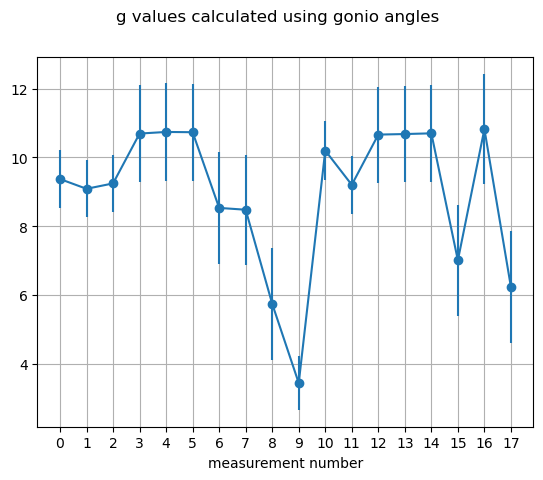

In [413]:
g_list = [val for val in g_dic.values()]
u_g_list = [val for val in u_g_dic.values()]

g_list_f = [val for val in g_f_dic.values()]
u_g_f_list = [val for val in u_g_f_dic.values()]


g_arr = np.array(g_list + g_list_f)
u_g_arr = np.array(u_g_list + u_g_f_list)




domain = [f'{i}' for i in range(len(g_arr))]

plt.scatter(domain, g_arr)
plt.suptitle("g values calculated using gonio angles")
#plt.plot(domain, np.ones_like(g_arr)*9.81)
plt.errorbar(domain, g_arr, yerr=u_g_arr)
plt.xlabel('measurement number')
plt.grid(True)
plt.show()


### Cleaning the data

In [414]:

def data_cleanser(data, error, min_data_points=5):
    '''
    Discards not matching data using Chauvenet's criterion
    min_data_points is the minimum number data points that should be left
    '''
    data_cp = np.copy(data)
    error_cp = np.copy(error)
    N = len(data_cp)
    mean, sigma = constant_fit(data_cp, error_cp)
    criterion = N*sp.special.erfc(np.abs(data_cp - mean)/sigma)
    
    while np.any(criterion < 0.5) and len(data_cp) > min_data_points:   
        criterion_s = np.sort(criterion)    # sorted, so we know where the lowest value is
        lowest_crit = criterion_s[0]        # get the lowest value of the criterion
        index = np.where(criterion == lowest_crit)[0][0] # gets the index of the lowest value in the og criterion array
        data_cp = np.delete(data_cp, index)  # data array without the "worst" value
        error_cp = np.delete(error_cp, index)
        N = len(data_cp)
        mean, sigma = constant_fit(data_cp, error_cp)
        criterion = N*sp.special.erfc(np.abs(data_cp - mean)/sigma)  # new criterion array calculated for the cleaned data
    return data_cp, error_cp

min_gonio_data = len(g_arr)*0.68
g_clean, u_g_clean = data_cleanser(g_arr, u_g_arr, min_gonio_data)  # the number of minimal data yet to be established
print('Values of g using gonio after cleansing:')
for i in range(len(g_clean)):
    print(f'{i}: g = {g_clean[i]:.2f}, error = {u_g_clean[i]:.2f}')




Values of g using gonio after cleansing:
0: g = 9.37, error = 0.85
1: g = 9.09, error = 0.83
2: g = 9.24, error = 0.84
3: g = 10.69, error = 1.40
4: g = 10.74, error = 1.42
5: g = 10.73, error = 1.41
6: g = 10.20, error = 0.85
7: g = 9.20, error = 0.83
8: g = 10.66, error = 1.39
9: g = 10.68, error = 1.40
10: g = 10.70, error = 1.40
11: g = 10.82, error = 1.60


Visualizing the data after cleansing

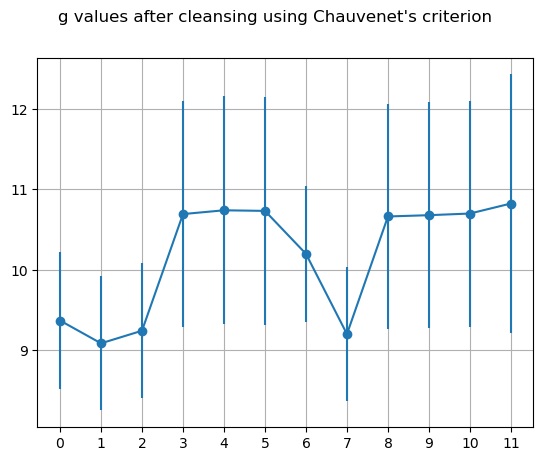

In [415]:

domain = [f'{i}' for i in range(len(g_clean))]

plt.scatter(domain, g_clean)
plt.suptitle("g values after cleansing using Chauvenet's criterion ")
#plt.plot(domain, np.ones_like(g_clean)*9.81)
plt.errorbar(domain, g_clean, yerr=u_g_clean)
plt.grid(True)
plt.show()


### Obtaining g values, but the trigonometric angles are used
It has been done for each ball and try which results in 27 non-flipped and 27 flipped results

In [416]:
# a_dic, u_a_dic, a_f_dic, u_a_f_dic
# angle_{name}, u_angle_{name}, angle_table                      gonio is also a name :)))
# g_incline()


a1_arr = np.array([a_dic[key1] for key1 in fixed_keys[:3]])
u_a1_arr = np.array([u_a_dic[key1] for key1 in fixed_keys[:3]])

a2_arr = np.array([a_dic[key2] for key2 in fixed_keys[3:6]])
u_a2_arr = np.array([u_a_dic[key2] for key2 in fixed_keys[3:6]])

a3_arr = np.array([a_dic[key3] for key3 in fixed_keys[6:]])
u_a3_arr = np.array([u_a_dic[key3] for key3 in fixed_keys[6:]])

angles_trig = angles_arr[:-2]
u_angles_trig = u_angles_arr[:-2]


g1_list = []    # will held g values calculated for the ball 1, but using different trig angles 
u_g1_list = []
for a, u_a in zip(a1_arr, u_a1_arr):
    for angle, u_angle in zip(angles_trig, u_angles_trig):
        g1_list.append(g_fun(a, angle, -angle_table, D1, d))
        u_g1_list.append(u_g_fun(a, u_a, angle, u_angle, -angle_table, u_angle_gonio, D1, u_D, d, u_d))

g2_list = []
u_g2_list = []
for a, u_a in zip(a2_arr, u_a2_arr):
    for angle, u_angle in zip(angles_trig, u_angles_trig):
        g2_list.append(g_fun(a, angle, -angle_table, D2, d))
        u_g2_list.append(u_g_fun(a, u_a, angle, u_angle, -angle_table, u_angle_gonio, D2, u_D, d, u_d))

g3_list = []
u_g3_list = []
for a, u_a in zip(a3_arr, u_a3_arr):
    for angle, u_angle in zip(angles_trig, u_angles_trig):
        g3_list.append(g_fun(a, angle, -angle_table, D3, d))
        u_g3_list.append(u_g_fun(a, u_a, angle, u_angle, -angle_table, u_angle_gonio, D3, u_D, d, u_d))

g_trig_arr = np.array(g1_list + g2_list + g3_list)
u_g_trig_arr = np.array(u_g1_list + u_g2_list + u_g3_list)


# Repeat the same for the flipped incline :))

a1_f_arr = np.array([a_f_dic[key1] for key1 in fixed_keys[:3]])
u_a1_f_arr = np.array([u_a_f_dic[key1] for key1 in fixed_keys[:3]])

a2_f_arr = np.array([a_f_dic[key2] for key2 in fixed_keys[3:6]])
u_a2_f_arr = np.array([u_a_f_dic[key2] for key2 in fixed_keys[3:6]])

a3_f_arr = np.array([a_f_dic[key3] for key3 in fixed_keys[6:]])
u_a3_f_arr = np.array([u_a_f_dic[key3] for key3 in fixed_keys[6:]])




g1_f_list = []
u_g1_f_list = []
for a, u_a in zip(a1_f_arr, u_a1_f_arr):
    for angle, u_angle in zip(angles_trig, u_angles_trig):
        g1_f_list.append(g_fun(a, angle, angle_table, D1, d))
        u_g1_f_list.append(u_g_fun(a, u_a, angle, u_angle, angle_table, u_angle_gonio, D1, u_D, d, u_d))

g2_f_list = []
u_g2_f_list = []
for a, u_a in zip(a2_f_arr, u_a2_f_arr):
    for angle, u_angle in zip(angles_trig, u_angles_trig):
        g2_f_list.append(g_fun(a, angle, angle_table, D2, d))
        u_g2_f_list.append(u_g_fun(a, u_a, angle, u_angle, angle_table, u_angle_gonio, D2, u_D, d, u_d))

g3_f_list = []
u_g3_f_list = []
for a, u_a in zip(a3_f_arr, u_a3_f_arr):
    for angle, u_angle in zip(angles_trig, u_angles_trig):
        g3_f_list.append(g_fun(a, angle, angle_table, D3, d))
        u_g3_f_list.append(u_g_fun(a, u_a, angle, u_angle, angle_table, u_angle_gonio, D3, u_D, d, u_d))

g_trig_f_arr = np.array(g1_f_list + g2_f_list + g3_f_list)
u_g_trig_f_arr = np.array(u_g1_f_list + u_g2_f_list + u_g3_f_list)

print('Results of g values obtained using trig angles for non and flipped system:')
for i in range(len(g_trig_arr)):
    print(f'{i}: g = {g_trig_arr[i]:.2f}, error = {u_g_trig_arr[i]:.2f}; flipped: g = {g_trig_f_arr[i]:.2f}, error = {u_g_trig_f_arr[i]:.2f}')



Results of g values obtained using trig angles for non and flipped system:
0: g = 9.44, error = 0.86; flipped: g = 3.42, error = 0.85
1: g = 9.54, error = 0.87; flipped: g = 3.45, error = 0.85
2: g = 9.46, error = 0.86; flipped: g = 3.43, error = 0.85
3: g = 9.16, error = 0.84; flipped: g = 10.13, error = 0.86
4: g = 9.25, error = 0.85; flipped: g = 10.24, error = 0.86
5: g = 9.18, error = 0.84; flipped: g = 10.15, error = 0.86
6: g = 9.31, error = 0.85; flipped: g = 9.14, error = 0.85
7: g = 9.41, error = 0.86; flipped: g = 9.24, error = 0.86
8: g = 9.33, error = 0.85; flipped: g = 9.16, error = 0.86
9: g = 9.79, error = 1.24; flipped: g = 9.62, error = 1.21
10: g = 9.89, error = 1.25; flipped: g = 9.72, error = 1.23
11: g = 9.81, error = 1.24; flipped: g = 9.64, error = 1.22
12: g = 9.83, error = 1.25; flipped: g = 9.64, error = 1.19
13: g = 9.93, error = 1.26; flipped: g = 9.74, error = 1.21
14: g = 9.85, error = 1.25; flipped: g = 9.66, error = 1.20
15: g = 9.82, error = 1.25; flip

Visualizing the trigonometry data

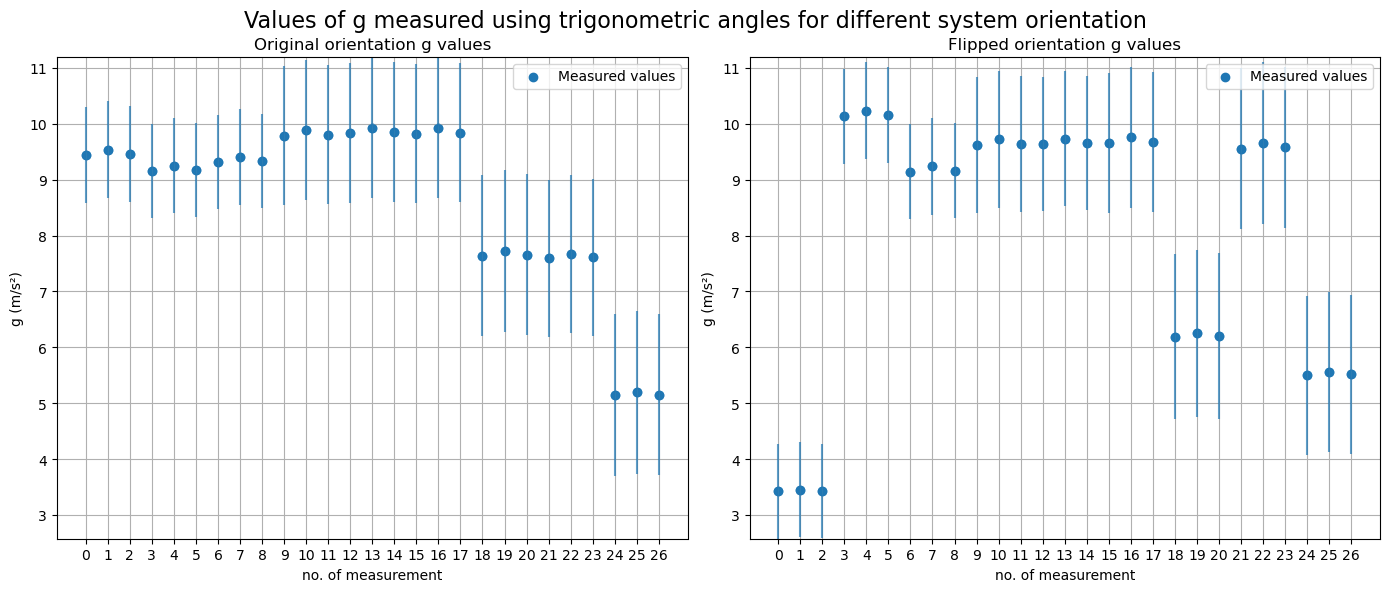

In [417]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
domain = [f'{i}' for i in range(len(g_trig_arr))]

ax1.scatter(domain, g_trig_arr, label='Measured values')
# ax1.hlines(9.81, -1, len(domain), colors='r', linestyles='dashed', label='Expected g')
ax1.errorbar(domain, g_trig_arr, yerr=u_g_trig_arr, fmt='o', alpha=0.7)
ax1.set_title('Original orientation g values')
ax1.set_xlabel('no. of measurement')
ax1.set_ylabel('g (m/s²)')
ax1.grid(True)
ax1.legend()

ax2.scatter(domain, g_trig_f_arr, label='Measured values')
# ax2.hlines(9.81, -1, len(domain), colors='r', linestyles='dashed', label='Expected g')
ax2.errorbar(domain, g_trig_f_arr, yerr=u_g_trig_f_arr, fmt='o', alpha=0.7)
ax2.set_title('Flipped orientation g values')
ax2.set_xlabel('no. of measurement')
ax2.set_ylabel('g (m/s²)')
ax2.grid(True)
ax2.legend()

y_min = min(min(g_trig_arr - u_g_trig_arr), min(g_trig_f_arr - u_g_trig_f_arr))
y_max = max(max(g_trig_arr + u_g_trig_arr), max(g_trig_f_arr + u_g_trig_f_arr))
ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Values of g measured using trigonometric angles for different system orientation', fontsize=16)

plt.show()

### Cleaning the trigonometric data

In [418]:
min_trig_data = len(g_trig_arr)*0.68
g_trig_cl, u_g_trig_cl = data_cleanser(g_trig_arr, u_g_trig_arr, min_trig_data)
g_trig_f_cl, u_g_trig_f_cl = data_cleanser(g_trig_f_arr, u_g_trig_arr, min_trig_data)

for i in range(len(g_trig_cl)):
    print(f'{i}: g = {g_trig_cl[i]:.2f}, error = {u_g_trig_cl[i]:.2f}; flipped g = {g_trig_f_cl[i]:.2f}, error = {u_g_trig_f_cl[i]:.2f}')

0: g = 9.44, error = 0.86; flipped g = 10.13, error = 0.84
1: g = 9.54, error = 0.87; flipped g = 10.24, error = 0.85
2: g = 9.46, error = 0.86; flipped g = 10.15, error = 0.84
3: g = 9.16, error = 0.84; flipped g = 9.14, error = 0.85
4: g = 9.25, error = 0.85; flipped g = 9.24, error = 0.86
5: g = 9.18, error = 0.84; flipped g = 9.16, error = 0.85
6: g = 9.31, error = 0.85; flipped g = 9.62, error = 1.24
7: g = 9.41, error = 0.86; flipped g = 9.72, error = 1.25
8: g = 9.33, error = 0.85; flipped g = 9.64, error = 1.24
9: g = 9.79, error = 1.24; flipped g = 9.64, error = 1.25
10: g = 9.89, error = 1.25; flipped g = 9.74, error = 1.26
11: g = 9.81, error = 1.24; flipped g = 9.66, error = 1.25
12: g = 9.83, error = 1.25; flipped g = 9.66, error = 1.25
13: g = 9.93, error = 1.26; flipped g = 9.76, error = 1.26
14: g = 9.85, error = 1.25; flipped g = 9.68, error = 1.25
15: g = 9.82, error = 1.25; flipped g = 9.56, error = 1.40
16: g = 9.93, error = 1.26; flipped g = 9.66, error = 1.42
17: 

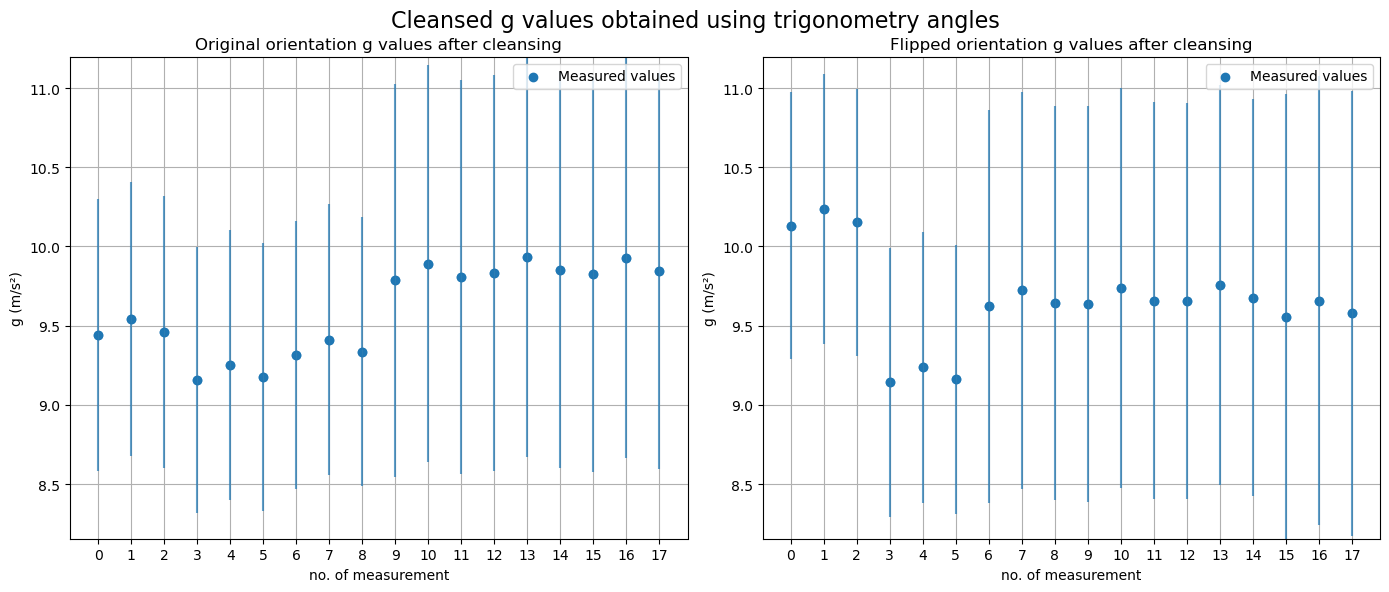

In [419]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

domain = [f'{i}' for i in range(len(g_trig_cl))]
domain_f = [f'{i}' for i in range(len(g_trig_f_cl))]
# First subplot
ax1.scatter(domain, g_trig_cl, label='Measured values')
# ax1.hlines(9.81, -1, len(domain), colors='r', linestyles='dashed', label='Expected g')
ax1.errorbar(domain, g_trig_cl, yerr=u_g_trig_cl, fmt='o', alpha=0.7)
ax1.set_title('Original orientation g values after cleansing')
ax1.set_xlabel('no. of measurement')
ax1.set_ylabel('g (m/s²)')
ax1.grid(True)
ax1.legend()
# Second subplot
ax2.scatter(domain_f, g_trig_f_cl, label='Measured values')
# ax2.hlines(9.81, -1, len(domain_f), colors='r', linestyles='dashed', label='Expected g')
ax2.errorbar(domain_f, g_trig_f_cl, yerr=u_g_trig_f_cl, fmt='o', alpha=0.7)
ax2.set_title('Flipped orientation g values after cleansing')
ax2.set_xlabel('no. of measurement')
ax2.set_ylabel('g (m/s²)')
ax2.grid(True)
ax2.legend()
# Set consistent y-axis limits for comparison
y_min = min(min(g_trig_cl - u_g_trig_cl), min(g_trig_f_cl - u_g_trig_f_cl))
y_max = max(max(g_trig_cl + u_g_trig_cl), max(g_trig_f_cl + u_g_trig_f_cl))
ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)

# Adjust layout and add a figure title
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Cleansed g values obtained using trigonometry angles', fontsize=16)

plt.show()

# Calculating the mean g out of the cleansed data to obtain one g representative

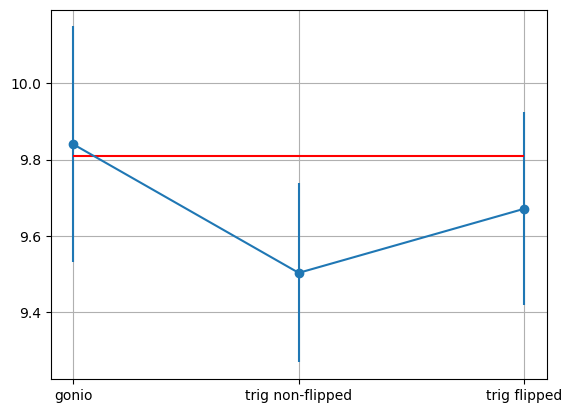

After all g = 9.64, error = 0.15
sigma interval: [9.492; 9.793]


In [423]:
g_gonio_mean, u_g_gonio_mean = constant_fit(g_clean, u_g_clean)
g_trig_mean, u_g_trig_mean = constant_fit(g_trig_cl, u_g_trig_cl)
g_trig_f_mean, u_g_trig_f_mean = constant_fit(g_trig_f_cl, u_g_trig_f_cl)

g_overall = np.array([g_gonio_mean, g_trig_mean, g_trig_f_mean])
u_g_overall = np.array([u_g_gonio_mean, u_g_trig_mean, u_g_trig_f_mean])

domain_overall = ['gonio', 'trig non-flipped', 'trig flipped']
plt.scatter(domain_overall, g_overall)
plt.errorbar(domain_overall, g_overall, yerr=u_g_overall)
plt.hlines(9.81, 0, 2, colors='r')
plt.grid(True)
plt.show()

g_overall_mean, u_g_overall_mean = constant_fit(g_overall, u_g_overall)
print(f'After all g = {g_overall_mean:.2f}, error = {u_g_overall_mean:.2f}')
print(f'sigma interval: [{g_overall_mean - u_g_overall_mean:.3f}; {g_overall_mean + u_g_overall_mean:.3f}]')